# Exploratory Data Analysis
This Notebook focuses on data analysis so we can get a brighter idea of what our data suggests.


## Setup & Initialization
Setup of libraries, imports and directories.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_PATH = "/content/drive/MyDrive/LandslideDetection"
DATA_PATH = f"{BASE_PATH}/data"
img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"


Mounted at /content/drive


In [ ]:


!pip install tqdm

## Data Analysis
General data analysis to understand our dataset.

### Class Imbalance Test


In [ ]:

import glob, numpy as np, h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

Gather masks: 100%|██████████| 3799/3799 [01:00<00:00, 63.20it/s] 


Overall landslide pixel fraction: 2.3180%


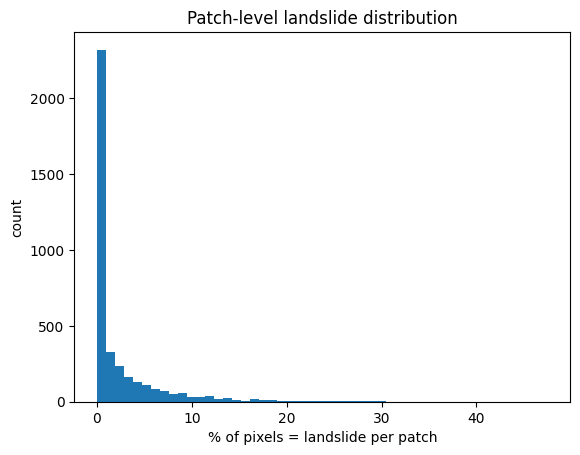

In [ ]:
import glob, numpy as np, h5py
from tqdm import tqdm

mask_files = sorted(glob.glob(f"{mask_dir}/*.h5"))

pixel_counts = []
patch_perc    = []

# 1) gather per-patch sums and per-patch percentages
for path in tqdm(mask_files, desc="Gather masks"):
    with h5py.File(path, 'r') as f:
        m = f['mask'][:]           # shape (H,W)
    flat = m.ravel()
    ones = flat.sum()
    pixel_counts.append(ones)
    patch_perc.append(100.0 * ones / flat.size)

# 2) total landslide pixels
total_ones  = int(np.sum(pixel_counts))

# 3) total pixels
#    we know each mask has the same shape, so we can just multiply shape by count of files:
with h5py.File(mask_files[0], 'r') as f0:
    single_size = f0['mask'][:].size
total_pixels = single_size * len(mask_files)

print(f"Overall landslide pixel fraction: {total_ones/total_pixels:.4%}")

# 4) plot
import matplotlib.pyplot as plt

plt.hist(patch_perc, bins=50)
plt.xlabel("% of pixels = landslide per patch")
plt.ylabel("count")
plt.title("Patch-level landslide distribution")
plt.show()

Mask inspection below:

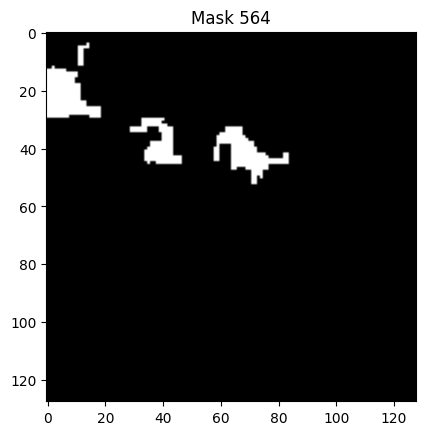

In [ ]:
import random
idx = random.randrange(len(mask_files))
with h5py.File(mask_files[idx],'r') as f:
    m = f['mask'][:]
plt.imshow(m, cmap='gray'); plt.title(f"Mask {idx}"); plt.show()

### Band Analysis

Gathering image stats: 100%|██████████| 3799/3799 [06:08<00:00, 10.32it/s]


Band 00:  mean=0.926,  std=0.141
Band 01:  mean=0.923,  std=0.221
Band 02:  mean=0.954,  std=0.318
Band 03:  mean=0.960,  std=0.572
Band 04:  mean=1.023,  std=0.460
Band 05:  mean=1.043,  std=0.447
Band 06:  mean=1.036,  std=0.465
Band 07:  mean=1.047,  std=0.495
Band 08:  mean=1.170,  std=0.513
Band 09:  mean=1.174,  std=0.684
Band 10:  mean=1.049,  std=0.532
Band 11:  mean=1.037,  std=0.663
Band 12:  mean=1.251,  std=0.678
Band 13:  mean=1.650,  std=1.073


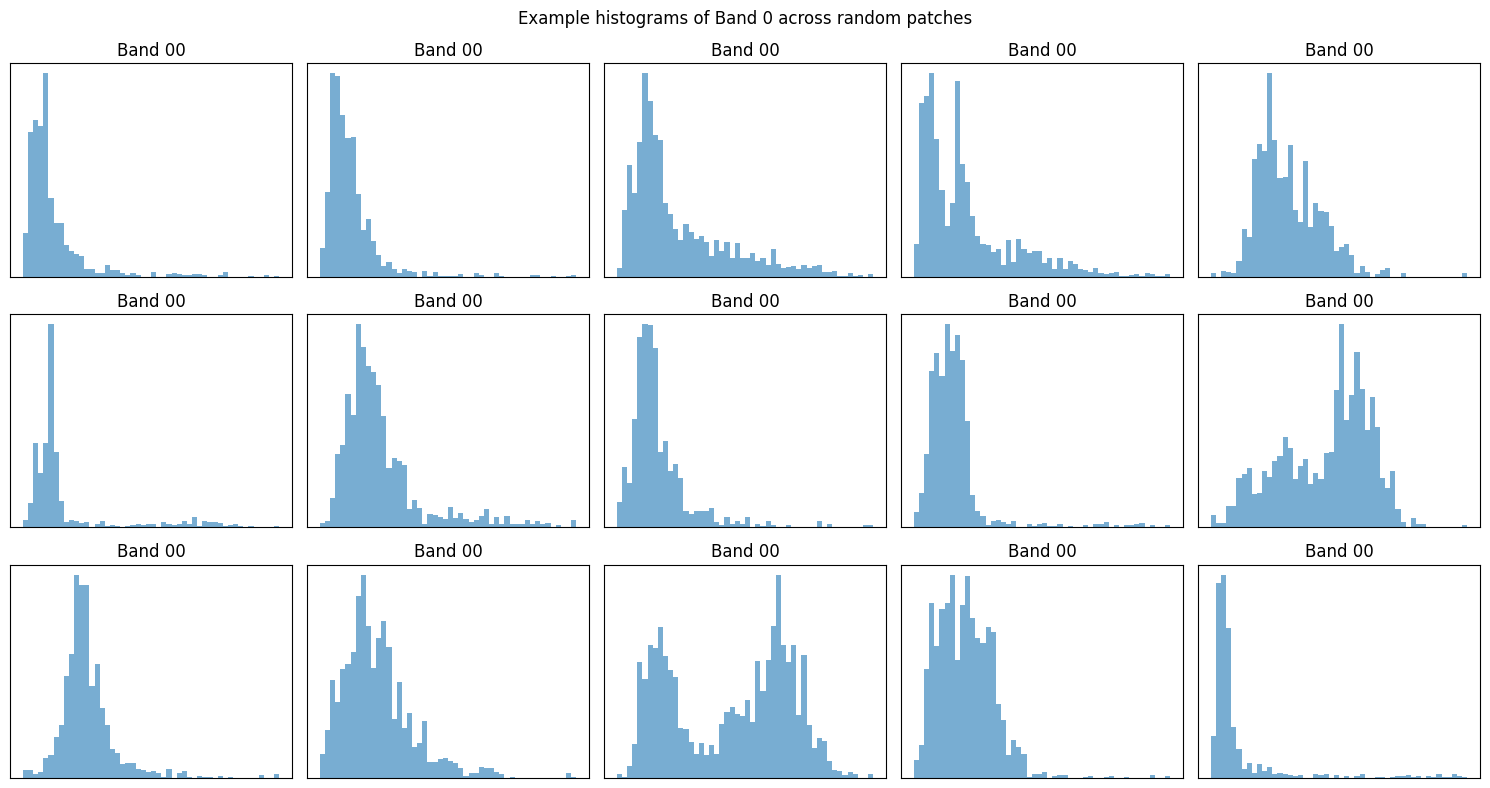

In [ ]:
import glob, h5py, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ── 1. Gather all image files ───────────────────────────────────────────────
img_dir    = f"{DATA_PATH}/TrainData/img"
img_files  = sorted(glob.glob(f"{img_dir}/*.h5"))

# ── 2. Initialize accumulators ────────────────────────────────────────────
# We'll accumulate per-band sums and sum of squares to get mean/std in one pass.
# We assume all images same shape: (H, W, C)= (128,128,14)
with h5py.File(img_files[0], 'r') as f0:
    H, W, C = f0['img'][:].shape
    Npix     = H * W

band_sum       = np.zeros(C, dtype=np.float64)
band_sumsq     = np.zeros(C, dtype=np.float64)
total_patches  = 0

# ── 3. Loop over every patch ──────────────────────────────────────────────
for path in tqdm(img_files, desc="Gathering image stats"):
    with h5py.File(path, 'r') as f:
        im = f['img'][:]   # shape (H,W,C)
    # reshape to (C, H*W)
    flat = im.reshape(-1, C)
    band_sum   += flat.sum(axis=0)
    band_sumsq += (flat**2).sum(axis=0)
    total_patches += 1

# ── 4. Compute mean & std for each band ──────────────────────────────────
total_pixels_all = total_patches * Npix
mean  = band_sum   / total_pixels_all
var   = (band_sumsq / total_pixels_all) - (mean**2)
std   = np.sqrt(var)

for b in range(C):
    print(f"Band {b:02d}:  mean={mean[b]:.3f},  std={std[b]:.3f}")

# ── 5. Plot histograms for a random subset ───────────────────────────────
# (so we don’t plot millions of values)
import random
sample_paths = random.sample(img_files, 20)

fig, axes = plt.subplots(3,5, figsize=(15,8))
axes = axes.flatten()

for ax, path in zip(axes, sample_paths):
    with h5py.File(path,'r') as f:
        im = f['img'][:]
    # pick one band to plot (e.g. band 0) or loop bands
    ax.hist(im[:,:,0].ravel(), bins=50, color='C0', alpha=0.6)
    ax.set_title("Band 00")
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Example histograms of Band 0 across random patches")
plt.tight_layout()
plt.show()

Detected image size = 128×128, number of bands = 14


Gathering image stats: 100%|██████████| 3799/3799 [00:38<00:00, 98.49it/s] 


Band 00: mean=0.926,  std=0.141
Band 01: mean=0.923,  std=0.221
Band 02: mean=0.954,  std=0.318
Band 03: mean=0.960,  std=0.572
Band 04: mean=1.023,  std=0.460
Band 05: mean=1.043,  std=0.447
Band 06: mean=1.036,  std=0.465
Band 07: mean=1.047,  std=0.495
Band 08: mean=1.170,  std=0.513
Band 09: mean=1.174,  std=0.684
Band 10: mean=1.049,  std=0.532
Band 11: mean=1.037,  std=0.663
Band 12: mean=1.251,  std=0.678
Band 13: mean=1.650,  std=1.073


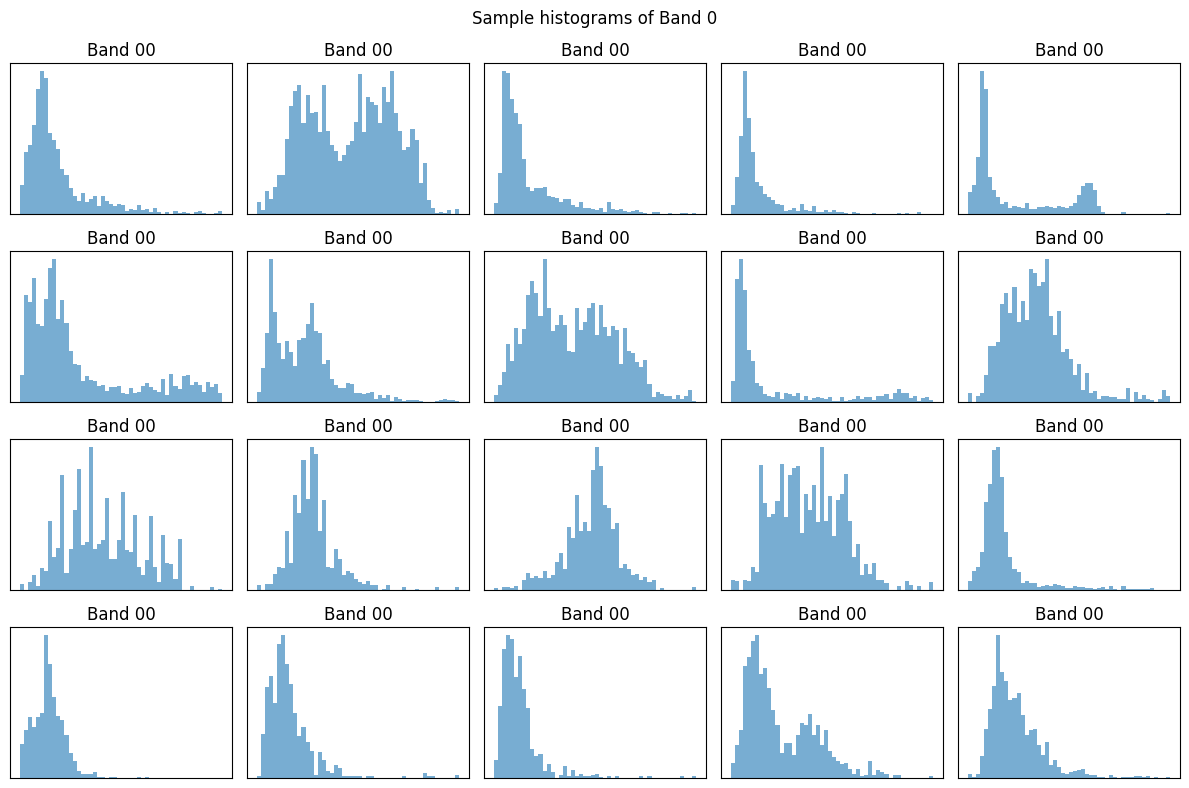

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1) point to your folder of .h5 images
img_dir   = f"{DATA_PATH}/TrainData/img"
img_files = sorted(glob.glob(f"{img_dir}/*.h5"))
assert len(img_files)>0, "No .h5 files found!"

# 2) open the first one to discover H, W, n_bands
with h5py.File(img_files[0], 'r') as f0:
    data0 = f0['img'][:]          # shape = (H, W, C)
    H, W, n_bands = data0.shape

print(f"Detected image size = {H}×{W}, number of bands = {n_bands}")

# 3) now compute per‐band mean/std in one pass
band_sum   = np.zeros(n_bands, dtype=np.float64)
band_sumsq = np.zeros(n_bands, dtype=np.float64)
total_patches = 0
Npix = H * W

for path in tqdm(img_files, desc="Gathering image stats"):
    with h5py.File(path,'r') as f:
        img = f['img'][:]               # (H, W, n_bands)
    flat = img.reshape(-1, n_bands)     # (H*W, C)
    band_sum   += flat.sum(axis=0)
    band_sumsq += (flat**2).sum(axis=0)
    total_patches += 1

# 4) finalize
total_pixels = total_patches * Npix
means = band_sum   / total_pixels
vars  = band_sumsq / total_pixels - means**2
stds  = np.sqrt(vars)

# 5) print results
for b in range(n_bands):
    print(f"Band {b:02d}: mean={means[b]:.3f},  std={stds[b]:.3f}")

# 6) Example histograms for band 0
sample_paths = np.random.choice(img_files, size=20, replace=False)
fig, axes = plt.subplots(4,5, figsize=(12,8))
axes = axes.flatten()

for ax, path in zip(axes, sample_paths):
    with h5py.File(path,'r') as f:
        img = f['img'][:]   # (H,W,C)
    ax.hist(img[:,:,0].ravel(), bins=50, alpha=0.6)
    ax.set_title("Band 00")
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle("Sample histograms of Band 0")
plt.tight_layout()
plt.show()

### Cohen's D Analysis
We wanted to go beyond raw histograms and eyeballing: Cohen’s D is the canonical “effect size” metric in statistics that normalizes the mean difference by the combined spread of the two groups. A high |d| means the two distributions barely overlap, so that band is potentially very powerful for segmentation. By ranking all 14 bands by their Cohen’s D we quickly identified the most informative channels to test in our ablation runs—letting us build a much lighter, faster model that still captures the lion’s share of the discriminative power

Accumulating land vs back: 100%|██████████| 3799/3799 [00:31<00:00, 122.13it/s]


Band 00 → mean_land=1.118, mean_back=0.921, d=1.318
Band 01 → mean_land=1.367, mean_back=0.912, d=1.613
Band 02 → mean_land=1.622, mean_back=0.938, d=1.648
Band 03 → mean_land=2.388, mean_back=0.926, d=1.883
Band 04 → mean_land=1.842, mean_back=1.003, d=1.548
Band 05 → mean_land=1.030, mean_back=1.043, d=-0.034
Band 06 → mean_land=0.906, mean_back=1.039, d=-0.340
Band 07 → mean_land=0.889, mean_back=1.050, d=-0.384
Band 08 → mean_land=1.107, mean_back=1.171, d=-0.140
Band 09 → mean_land=1.319, mean_back=1.170, d=0.189
Band 10 → mean_land=1.466, mean_back=1.040, d=0.770
Band 11 → mean_land=2.155, mean_back=1.010, d=1.463
Band 12 → mean_land=1.623, mean_back=1.242, d=0.619
Band 13 → mean_land=1.912, mean_back=1.643, d=0.260


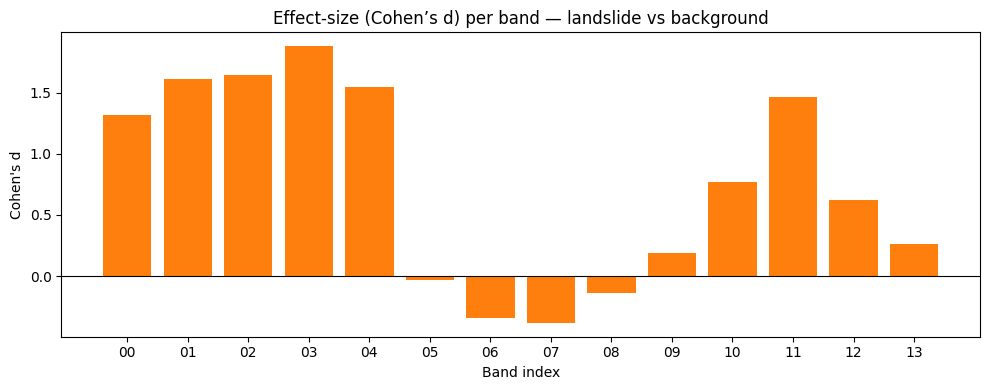

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1) point to your folders
img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"
img_files  = sorted(glob.glob(f"{img_dir}/*.h5"))
mask_files = sorted(glob.glob(f"{mask_dir}/*.h5"))
assert len(img_files)==len(mask_files)>0, "Make sure images & masks line up!"

# discover dims
with h5py.File(img_files[0],'r') as f0:
    H, W, C = f0['img'][:].shape
Npix = H*W

# 2) allocate accumulators
land_sum   = np.zeros(C, dtype=np.float64)
land_sumsq = np.zeros(C, dtype=np.float64)
back_sum   = np.zeros(C, dtype=np.float64)
back_sumsq = np.zeros(C, dtype=np.float64)
land_count = 0
back_count = 0

# 3) one more pass: split by mask
for im_path, m_path in tqdm(zip(img_files, mask_files),
                            total=len(img_files),
                            desc="Accumulating land vs back"):
    with h5py.File(im_path,'r') as f:   img = f['img'][:]            # (H,W,C)
    with h5py.File(m_path,'r') as f:    msk = f['mask'][:].astype(bool) # (H,W)

    # flatten to (Npix, C)
    flat_img = img.reshape(-1, C)
    flat_m   = msk.ravel()

    # landslide pixels
    land_pixels = flat_img[flat_m]
    land_sum   += land_pixels.sum(axis=0)
    land_sumsq += (land_pixels**2).sum(axis=0)
    land_count += land_pixels.shape[0]

    # background pixels
    back_pixels = flat_img[~flat_m]
    back_sum   += back_pixels.sum(axis=0)
    back_sumsq += (back_pixels**2).sum(axis=0)
    back_count += back_pixels.shape[0]

# 4) compute means & stds
mean_land = land_sum   / land_count
mean_back = back_sum   / back_count

var_land  = land_sumsq / land_count - mean_land**2
var_back  = back_sumsq / back_count - mean_back**2
std_land  = np.sqrt(var_land)
std_back  = np.sqrt(var_back)

# 5) Cohen’s d
pooled_std = np.sqrt((std_land**2 + std_back**2)/2)
cohens_d   = (mean_land - mean_back) / pooled_std

# 6) print & plot
for b in range(C):
    print(f"Band {b:02d} → mean_land={mean_land[b]:.3f}, mean_back={mean_back[b]:.3f}, d={cohens_d[b]:.3f}")

plt.figure(figsize=(10,4))
plt.bar(np.arange(C), cohens_d, color='C1')
plt.axhline(0, color='k', linewidth=0.8)
plt.xticks(np.arange(C), [f"{i:02d}" for i in range(C)])
plt.ylabel("Cohen's d")
plt.xlabel("Band index")
plt.title("Effect‐size (Cohen’s d) per band — landslide vs background")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np, glob, h5py
from tqdm import tqdm

img_dir   = f"{DATA_PATH}/TrainData/img"
mask_dir  = f"{DATA_PATH}/TrainData/mask"
img_files = sorted(glob.glob(f"{img_dir}/*.h5"))
msk_files = sorted(glob.glob(f"{mask_dir}/*.h5"))

# accumulators
sum_land = sum_back = 0.0
cnt_land = cnt_back = 0

for im_p, ms_p in tqdm(zip(img_files, msk_files), total=len(img_files)):
    with h5py.File(im_p,'r') as f: img = f['img'][:,:,3].ravel()   # band 3
    with h5py.File(ms_p,'r') as f: msk = f['mask'][:].ravel()

    sum_land += img[msk==1].sum()
    cnt_land += int((msk==1).sum())
    sum_back += img[msk==0].sum()
    cnt_back += int((msk==0).sum())

μ_land = sum_land / cnt_land
μ_back = sum_back / cnt_back
thresh = 0.5*(μ_land + μ_back)
print(f"band 3: μ_land={μ_land:.3f}, μ_back={μ_back:.3f}, threshold={thresh:.3f}")


100%|██████████| 3799/3799 [00:24<00:00, 152.73it/s]

band 3: μ_land=2.388, μ_back=0.926, threshold=1.657


In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score

# load your val lists exactly as above
val_imgs = sorted(glob.glob(f"{DATA_PATH}/ValData/img/*.h5"))
val_msks = sorted(glob.glob(f"{DATA_PATH}/ValData/mask/*.h5"))

y_true, y_pred = [], []
for im_p, ms_p in zip(val_imgs, val_msks):
    with h5py.File(im_p,'r') as f: im3 = f['img'][:,:,3].ravel()
    with h5py.File(ms_p,'r') as f: gt  = f['mask'][:].ravel()

    pred = (im3>thresh).astype(int)
    y_true.extend(gt)
    y_pred.extend(pred)

print("Single‐band (band 3) results:")
print("  F1      ", f1_score(y_true,y_pred))
print("  Precision", precision_score(y_true,y_pred))
print("  Recall   ", recall_score(y_true,y_pred))

Single‐band (band 3) results:
  F1       0.0
  Precision 0.0
  Recall    0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Correlation Matrices
The reason I brought in the correlation‐matrix step (and the little bit of code around it) was to get a second, complementary view onto how those 14 bands relate to one another—and in particular whether any of them are almost linearly redundant.

Computing patch means: 100%|██████████| 3799/3799 [00:36<00:00, 105.51it/s]


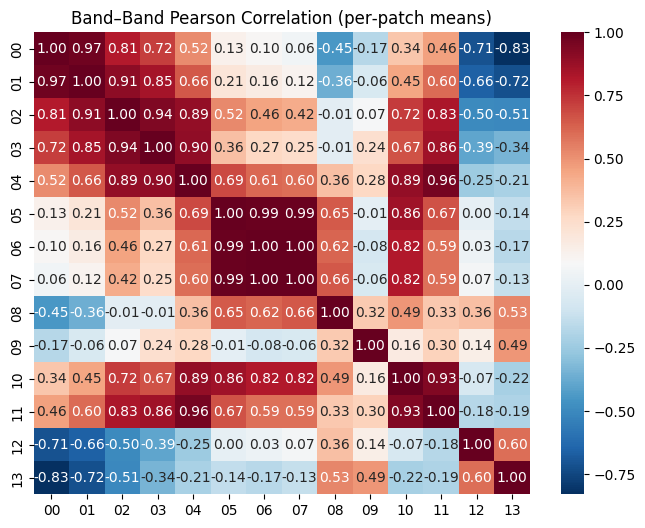

In [ ]:
import glob, h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1) collect per‐patch band means
img_dir   = f"{DATA_PATH}/TrainData/img"
img_files = sorted(glob.glob(f"{img_dir}/*.h5"))

patch_means = []
for p in tqdm(img_files, desc="Computing patch means"):
    with h5py.File(p,'r') as f:
        im = f['img'][:]        # (H,W,C)
    patch_means.append(im.reshape(-1, im.shape[-1]).mean(axis=0))

patch_means = np.vstack(patch_means)  # shape = (n_patches, C)

# 2) compute correlation matrix
corr = np.corrcoef(patch_means, rowvar=False)  # (C,C)

# 3) plot
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r",
            xticklabels=[f"{i:02d}" for i in range(corr.shape[0])],
            yticklabels=[f"{i:02d}" for i in range(corr.shape[0])])
plt.title("Band–Band Pearson Correlation (per‐patch means)")
plt.show()

Computing mask fractions: 100%|██████████| 3799/3799 [00:29<00:00, 130.16it/s]


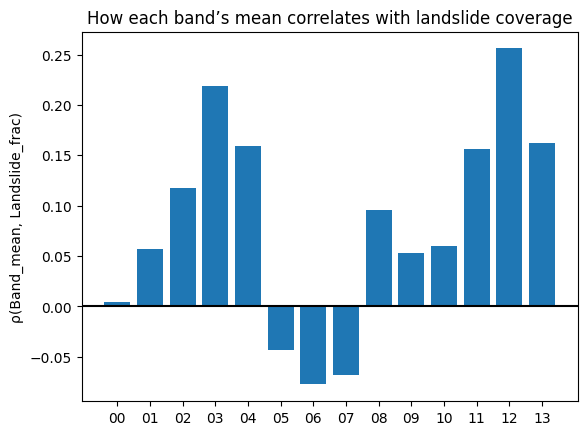

In [ ]:
mask_dir = f"{DATA_PATH}/TrainData/mask"
mask_files = sorted(glob.glob(f"{mask_dir}/*.h5"))

fractions = []
for m in tqdm(mask_files, desc="Computing mask fractions"):
    with h5py.File(m,'r') as f:
        mask = f['mask'][:]  # (H,W)
    fractions.append(mask.ravel().mean())  # percent of landslide

fractions = np.array(fractions)  # shape=(n_patches,)

# compute band→fraction Pearson ρ
band_frac_corr = [np.corrcoef(patch_means[:,b], fractions)[0,1]
                  for b in range(patch_means.shape[1])]

plt.bar(range(len(band_frac_corr)), band_frac_corr)
plt.xticks(range(len(band_frac_corr)), [f"{i:02d}" for i in range(len(band_frac_corr))])
plt.ylabel("ρ(Band_mean, Landslide_frac)")
plt.title("How each band’s mean correlates with landslide coverage")
plt.axhline(0, color='k')
plt.show()

### PCA of Patch-means & Explained Variance

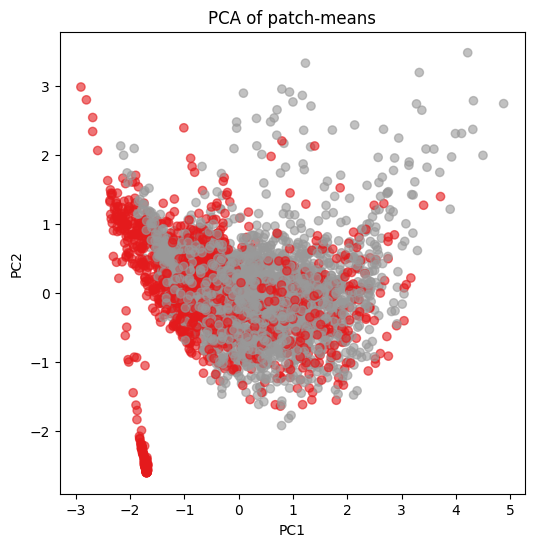

Explained variance ratio: [0.53801073 0.24647893 0.11956732]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(3)
pcs = pca.fit_transform(patch_means)

# simple scatter of PC1 vs PC2, colored by landslide fraction > 0
labels = (fractions>0).astype(int)
plt.figure(figsize=(6,6))
plt.scatter(pcs[:,0], pcs[:,1], c=labels, alpha=0.6, cmap="Set1")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA of patch‐means")
plt.show()
print("Explained variance ratio:", pca.explained_variance_ratio_)

### Quick 2-Band Baseline
Using just the two best bands (03 & 12), I trained a tiny Logistic Regression on patch-means and/or did a simple threshold scan. This was to check the ceiling you’d get if you only looked at two channels.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# 1) assemble X = per‐patch means of your two best bands, y = (mask_frac>0)
X = patch_means[:, [3,12]]           # band 03 and band 12
y = (fractions>0).astype(int)        # 1 if any landslide, else 0

# 2) train‐test split
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# 3) fit a tiny logistic‐regression
clf = LogisticRegression(class_weight='balanced').fit(Xtr, ytr)

# 4) evaluate
yhat = clf.predict(Xte)
print("F1:", f1_score(yte, yhat))
best_b1, best_b2 = 3, 12
# find per‐band thresholds by scanning
from sklearn.metrics import f1_score

vals1 = patch_means[:, best_b1]
vals2 = patch_means[:, best_b2]

# grid‐search a pair of thresholds
t1s = np.linspace(vals1.min(), vals1.max(), 30)
t2s = np.linspace(vals2.min(), vals2.max(), 30)

best = (0,0,0)
for t1 in t1s:
    for t2 in t2s:
        # predict patch positive iff BOTH bands exceed their threshold
        ypred = ((vals1>t1)&(vals2>t2)).astype(int)
        f1 = f1_score(y, ypred)
        if f1>best[0]:
            best = (f1, t1, t2)

print("Best F1", best[0], "at t1,t2=", best[1:])

F1: 0.7990970654627539
Best F1 0.8049476688867745 at t1,t2= (np.float64(0.4781341298544308), np.float64(0.8555929639924281))


A pure threshold on band-03 & band-12 patch-means already nets F1≈0.80. Logistic Regression on those means hits F1≈0.80–0.81. Any small UNet or backbone‐heavy model really must beat ~0.80 F1 to prove it’s mining extra information beyond those two channels.

### Tiny U-Net Ablation (2-band)
I trained a mini U-Net that ingests only bands 03 & 12

In [ ]:
!pip install segmentation_models_pytorch
import os, glob
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 1) ---- A tiny Dataset that reads only band3 and band12 + mask ----
class LandslidePatchDataset(Dataset):
    def __init__(self, img_paths, mask_paths, bands=[3,12], transforms=None):
        self.imgs  = img_paths
        self.msks  = mask_paths
        self.bands = bands
        self.tf    = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # read image patch
        with h5py.File(self.imgs[idx],'r') as f:
            im = f['img'][:]           # shape (H,W,C=14)
        # select only the two bands and normalize to [0,1]
        x = im[..., self.bands].astype(np.float32) / 10000.0  # adjust scale if needed
        # read mask
        with h5py.File(self.msks[idx],'r') as f:
            m = f['mask'][:]           # shape (H,W)
        # to torch tensors:  CxHxW  and  1xHxW
        x = torch.from_numpy(x).permute(2,0,1)
        y = torch.from_numpy(m.astype(np.float32)).unsqueeze(0)

        if self.tf:
            x, y = self.tf(x, y)

        return x, y

# 2) ---- Paths & train/val split ----
DATA_PATH   = f"{BASE_PATH}/data"
img_dir     = os.path.join(DATA_PATH, "TrainData/img")
mask_dir    = os.path.join(DATA_PATH, "TrainData/mask")
imgs        = sorted(glob.glob(f"{img_dir}/*.h5"))
masks       = sorted(glob.glob(f"{mask_dir}/*.h5"))
# split
img_tr, img_va, m_tr, m_va = train_test_split(imgs, masks, test_size=0.2, random_state=0)

# 3) ---- DataLoaders ----
train_ds = LandslidePatchDataset(img_tr, m_tr)
val_ds   = LandslidePatchDataset(img_va, m_va)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# 4) ---- Model: tiny Unet with in_channels=2 ----
model = smp.Unet(
    encoder_name   = "resnet18",
    encoder_weights = None,
    in_channels    = 2,
    classes        = 1,
    activation     = None,
)

# 5) ---- Combined Dice+Focal loss ----
dice  = smp.losses.DiceLoss(mode='binary')
focal = smp.losses.FocalLoss(mode='binary')
def loss_fn(preds, targs):
    return dice(preds, targs) + focal(preds, targs)

# 6) ---- Optimizer & device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model.to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7) ---- One training epoch ----
model.train()
running_loss = 0.0
for xb, yb in tqdm(train_dl, desc="Training"):
    xb, yb = xb.to(device), yb.to(device)
    preds  = model(xb)
    loss   = loss_fn(preds, yb)
    opt.zero_grad()
    loss.backward()
    opt.step()
    running_loss += loss.item() * xb.size(0)

epoch_loss = running_loss / len(train_ds)
print(f"Train Loss: {epoch_loss:.4f}")

# 8) ---- One validation epoch (just to check) ----
model.eval()
val_loss = 0.0
with torch.no_grad():
    for xb, yb in tqdm(val_dl, desc="Validating"):
        xb, yb = xb.to(device), yb.to(device)
        preds  = model(xb)
        loss   = loss_fn(preds, yb)
        val_loss += loss.item() * xb.size(0)

val_loss /= len(val_ds)
print(f"Val Loss:   {val_loss:.4f}")

Training: 100%|██████████| 380/380 [00:35<00:00, 10.70it/s]


Train Loss: 0.6738


Validating: 100%|██████████| 95/95 [00:03<00:00, 24.20it/s]

Val Loss:   0.8658


In [ ]:
import os, glob, h5py
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp
from sklearn.metrics import f1_score
from tqdm import tqdm

# 1) Dataset ------------------------------------------------
class H5SegDataset(Dataset):
    def __init__(self, img_files, mask_files, bands=[3,12], transform=None):
        self.img_files  = img_files
        self.mask_files = mask_files
        self.bands      = bands
        self.transform  = transform
    def __len__(self):
        return len(self.img_files)
    def __getitem__(self, i):
        with h5py.File(self.img_files[i],'r') as f:
            img = f['img'][:]       # (H,W,C)
        with h5py.File(self.mask_files[i],'r') as f:
            m  = f['mask'][:]       # (H,W)
        # pick only our two bands, cast to float32, normalize [0,1] by global means/stds if you want
        x = img[:,:, self.bands ].transpose(2,0,1).astype(np.float32)
        y = m.astype(np.float32)[None,...]  # shape (1,H,W)
        if self.transform:
            x,y = self.transform(x,y)
        return torch.tensor(x), torch.tensor(y)

# 2) Gather files + train/val split --------------------------
all_imgs  = sorted(glob.glob(f"{img_dir}/*.h5"))
all_masks = sorted(glob.glob(f"{mask_dir}/*.h5"))
assert len(all_imgs)==len(all_masks)>0

dataset = H5SegDataset(all_imgs, all_masks, bands=[3,12])
n_val    = int(len(dataset)*0.2)
n_train  = len(dataset) - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# 3) Model + loss + optimizer -------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
    encoder_name   = "resnet18",
    encoder_weights = None,
    in_channels    = 2,
    classes        = 1,
).to(device)

bce_loss  = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')
optimizer  = torch.optim.Adam(model.parameters(), lr=3e-4)

def combined_loss(logits, target):
    b = bce_loss(logits, target)
    d = dice_loss(logits, target)
    return b + d

# 4) Training + validation loop -----------------------------
n_epochs = 10
best_f1  = 0.0

for epoch in range(1, n_epochs+1):
    # ——— train —————————————————————————
    model.train()
    train_loss = 0
    for x,y in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss   = combined_loss(logits, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # ——— validate ————————————————————————
    model.eval()
    val_loss = 0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x,y in tqdm(val_loader, desc=f"Epoch {epoch} Validating"):
            x,y = x.to(device), y.to(device)
            logits = model(x)
            val_loss += combined_loss(logits, y).item()

            pred_mask = (torch.sigmoid(logits) > 0.5).float()
            all_preds.append(pred_mask.cpu().numpy().ravel())
            all_trues.append(y.cpu().numpy().ravel())

    val_loss /= len(val_loader)
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_trues)
    f1     = f1_score(y_true, y_pred)

    # ——— report —————————————————————————
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  F1={f1:.4f}")

    # save best
    if f1>best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_2band_unet.pth")

print("Training done. Best val F1:", best_f1)

Epoch 1 Validating: 100%|██████████| 48/48 [00:04<00:00, 11.31it/s]


Epoch 01 | train_loss=1.0154  val_loss=0.7420  F1=0.5502


Epoch 2 Validating: 100%|██████████| 48/48 [00:03<00:00, 12.26it/s]


Epoch 02 | train_loss=0.6168  val_loss=0.5832  F1=0.5646


Epoch 3 Validating: 100%|██████████| 48/48 [00:04<00:00, 11.77it/s]


Epoch 03 | train_loss=0.5390  val_loss=0.5586  F1=0.5717


Epoch 4 Validating: 100%|██████████| 48/48 [00:04<00:00, 11.96it/s]


Epoch 04 | train_loss=0.5131  val_loss=0.5143  F1=0.6032


Epoch 5 Validating: 100%|██████████| 48/48 [00:04<00:00, 11.80it/s]


Epoch 05 | train_loss=0.5092  val_loss=0.5385  F1=0.5808


Epoch 6 Validating: 100%|██████████| 48/48 [00:03<00:00, 12.34it/s]


Epoch 06 | train_loss=0.5032  val_loss=0.4986  F1=0.6175


Epoch 7 Validating: 100%|██████████| 48/48 [00:04<00:00, 11.78it/s]


Epoch 07 | train_loss=0.4870  val_loss=0.4766  F1=0.6339


Epoch 8 Validating: 100%|██████████| 48/48 [00:03<00:00, 12.06it/s]


Epoch 08 | train_loss=0.4691  val_loss=0.4821  F1=0.6300


Epoch 9 Validating: 100%|██████████| 48/48 [00:03<00:00, 12.29it/s]


Epoch 09 | train_loss=0.4654  val_loss=0.4909  F1=0.6177


Epoch 10 Validating: 100%|██████████| 48/48 [00:04<00:00, 11.81it/s]


Epoch 10 | train_loss=0.4622  val_loss=0.5523  F1=0.5674
Training done. Best val F1: 0.6338750858810592


This shows that just two channels fed into a convolutional network do not automatically recover the threshold‐based performance. We need a richer input (more bands or engineered features) or stronger architectural tweaks


## Conclusions


*   **Landslide Coverage Is Very Sparse**: Only 2.3 % of all pixels belong to landslides, and most 128×128 patches have <5 % landslide area, any model must overcome this imbalance.
*   **Redundant Bands Detected via Correlation**: Bands 05–06–07 correlate at R > 0.99 ⇒ effectively identical. Groups of highly intercorrelated channels (e.g. {B03–B04–B11–B12} vs. {B08–B09–B10–B13}) suggest we can drop duplicates and still cover most spectral information.
* **Top Discriminative Bands (Cohen’s d)**: Per‐pixel effect‐sizes (d) show that B03 (d≈1.9), B02 (d≈1.6), B04 (d≈1.5), B11 (d≈1.5) separate landslide from background best. B05–B07 have d≤0, so these add noise rather than signal
* **Band-Brightness vs. Landslide Fraction (Pearson ρ)**: Patch‐mean correlation with landslide coverage: B12 (ρ≈0.26), B03 (ρ≈0.22), B04 (ρ≈0.16), B13 (ρ≈0.16) are most positively associated. Bands 05–B07 remain weakly negatively correlated
* **Simple Two-Band Linear Baseline Is Already Strong**: A pure threshold rule on patch‐means of B03 & B12 yields F1≈0.80. Any model must exceed this threshold.
* **Two-Band Mini U-Net Underfits**: Training a small U-Net on only B03 & B12 achieved best F1≈0.63. A straightforward convolutional model with just two channels fails to recover the strong linear baseline.
